In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

In [3]:
def plotCSNS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

## Import data

In [4]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

lonW = 308
lonE = 327
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi]
tmask = mesh.tmask[0]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi]
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [5]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forpr_ros3','backadm_ros3','backvs_ros3','forpr_haro3','forgulf_haro3','backvs_haro3','backadm_haro3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2018,12,29)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass


In [6]:
dict_secdata = {}

for file in files:
    
    if file not in dict_secdata:
        dict_secdata[file] = {}
    
    for section in sectionnum:
        
        if section not in dict_secdata[file]:
            
            dict_secdata[file][section] = {}
            
        for date in dicts[file].keys():
            
            dict_secdata[file][section] = get_secdata(dicts[file][date],section)

In [7]:
dict_secdata['forpr_ros3'][0]['final_salt'].values

array([28.816092, 28.648008, 28.524025, ..., 31.01915 , 31.097898,
       30.336866], dtype=float32)

In [8]:
month_avg = np.zeros([12,len(sectransp_2018['forpr_ros3'].keys())])

for sectionnum in sectransp_2018['forpr_ros3'].keys():
    intermed = sectransp_2018['forpr_ros3'][sectionnum]
    for month in range(1,13):
        dates = [index for index, date in enumerate(datelist_vs) if date.month == month]
        selected_elements = [sectransp_2018['forpr_ros3'][sectionnum][index] for index in dates]
        month_avg[month-1,sectionnum] = np.mean(selected_elements)
    

In [9]:
dates = [index for index, date in enumerate(datelist_vs) if date.month == 1]
selected_elements = [sectransp_2018['forpr_ros3'][0][index] for index in dates]
date_jan = [datelist_vs for index in dates]

date = dt.datetime(2018,1,1)
enddate = dt.datetime(2019,1,1)

dates = []
datelist_yr = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_yr.append(date)
    date+=dt.timedelta(days=31)

In [10]:
datelist_yr

[datetime.datetime(2018, 1, 1, 0, 0),
 datetime.datetime(2018, 2, 1, 0, 0),
 datetime.datetime(2018, 3, 4, 0, 0),
 datetime.datetime(2018, 4, 4, 0, 0),
 datetime.datetime(2018, 5, 5, 0, 0),
 datetime.datetime(2018, 6, 5, 0, 0),
 datetime.datetime(2018, 7, 6, 0, 0),
 datetime.datetime(2018, 8, 6, 0, 0),
 datetime.datetime(2018, 9, 6, 0, 0),
 datetime.datetime(2018, 10, 7, 0, 0),
 datetime.datetime(2018, 11, 7, 0, 0),
 datetime.datetime(2018, 12, 8, 0, 0)]

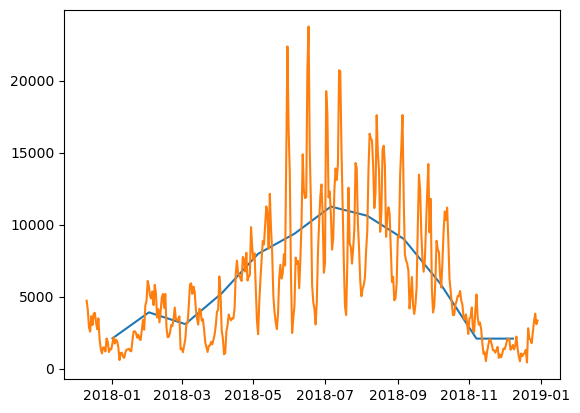

In [11]:
plt.plot(datelist_yr,month_avg[:,4])
plt.plot(datelist_vs,sectransp_2018['forpr_ros3'][4])

### Shifting functions

In [12]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

### Import density data

In [13]:
# Importing density and tidal data

density_ros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2018_rosarioNS.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)

density_rosVS = pd.read_csv('sigma_2018_rosariopr_202111_meanv2.csv')
dens_diff_rosVS = np.array(density_rosVS.south - density_rosVS.north)

density_haro = pd.read_csv('sigma_2018_harovs_202111_mean_v2.csv')
dens_diff_haro = np.array(density_haro.south - density_haro.north)

tides = pd.read_csv('low_pass_tide.csv')

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2018,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.iloc[:,1].shape)   
 
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2019,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
dens_diff_ros

730
(730,)


array([24.29067796, 24.300836  , 24.17309402, ..., 23.78621478,
       23.7777716 , 23.71792241])

In [14]:
wind = pd.read_csv('../notebooks/day_avg_wind.csv')
x = wind['time']
y = wind['wind']

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2019,12,31)
datelist_winds = []

while date <= enddate:
    datelist_winds.append(date)
    date+=dt.timedelta(days=1)
    
y_mean4 = y.rolling(window=4, center=True).mean()

#### Rosario to adm

In [15]:
PRtoadm_rosl = sectransp_2018['forpr_ros3'][2]
PRtoadm_rosbl = sectransp_2018['backadm_ros3'][4]

PRtoadm_ros = pd.Series(PRtoadm_rosl,index=datelist_vs)
PRtoadm_rosb = pd.Series(PRtoadm_rosbl,index=datelist_vs)

In [16]:
PRtoadm_rosb

2017-12-10     820.595292
2017-12-11    1149.001901
2017-12-12     749.904988
2017-12-13     707.988881
2017-12-14     889.198318
                 ...     
2018-12-25     511.828848
2018-12-26     455.538490
2018-12-27     789.910587
2018-12-28     606.814459
2018-12-29     413.102430
Length: 385, dtype: float64

In [17]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base,factor)
        dfr2 = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])

-0.8499999999999999 0.15000000000000102 0.6520339623467446
-0.7999999999999998 0.15000000000000102 0.6550074656313384
-0.7499999999999998 0.15000000000000102 0.6539740414298298


In [18]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.8] [0.15]


0.6550074656313384


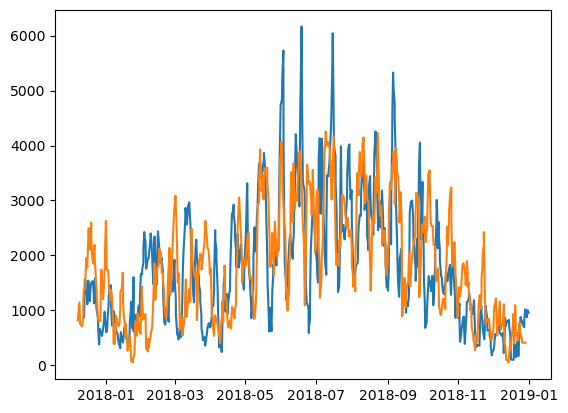

In [19]:
PRtoadm_ros_sh = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base_adm[0],factor_adm[0])
PRtoadm_rosb_sh = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtoadm_ros_m,PRtoadm_rosb_m,c,PRtoadm_ros_avg = merge(PRtoadm_ros_sh,PRtoadm_rosb_sh)
print(c)

plt.plot(PRtoadm_ros_m.Transport)
plt.plot(PRtoadm_rosb_m.Transport)

### PR to VicSill

In [20]:
PRtovs_rosl = sectransp_2018['forpr_ros3'][4]
PRtovs_rosbl = sectransp_2018['backvs_ros3'][4]

PRtovs_ros = pd.Series(PRtovs_rosl,index=datelist_vs)
PRtovs_rosb = pd.Series(PRtovs_rosbl,index=datelist_vs)

In [21]:
PRtovs_rosb

2017-12-10    1310.770747
2017-12-11    1871.730525
2017-12-12    1910.283706
2017-12-13    3093.747551
2017-12-14    5417.023974
                 ...     
2018-12-25     695.249195
2018-12-26     591.146689
2018-12-27     485.980272
2018-12-28     435.826136
2018-12-29     175.702814
Length: 385, dtype: float64

In [22]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base,factor)
        dfr2 = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.73:
            print (base, factor, corr_arr[i, j])

-1.0 0.30000000000000115 0.7383132790320881
-0.7499999999999998 0.2500000000000011 0.7303184671278201
-0.6499999999999997 0.2500000000000011 0.7314656453815972
-0.5999999999999996 0.2500000000000011 0.7307758320789479
-0.39999999999999947 0.2500000000000011 0.7304450300179869
-0.3499999999999994 0.2500000000000011 0.7342245171321491
0.15000000000000102 0.20000000000000107 0.7317687809152376
0.20000000000000107 0.20000000000000107 0.7339911066854952


In [23]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-1.] [0.3]


0.7383132790320881


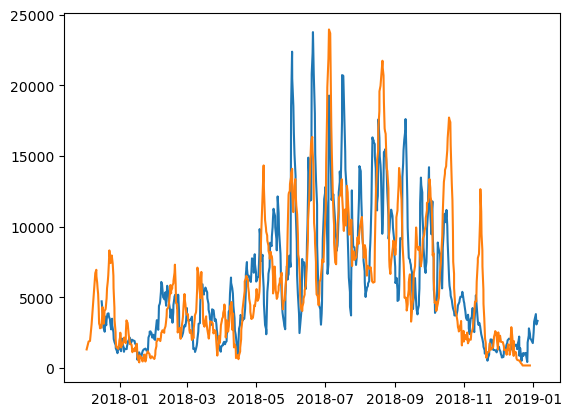

In [24]:
PRtovs_ros_sh = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base_adm[0],factor_adm[0])
PRtovs_rosb_sh = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtovs_ros_m,PRtovs_rosb_m,c,PRtovs_ros_avg = merge(PRtovs_ros_sh,PRtovs_rosb_sh)
print(c)

plt.plot(PRtovs_ros_m.Transport)
plt.plot(PRtovs_rosb_m.Transport)

0.8292558573214036


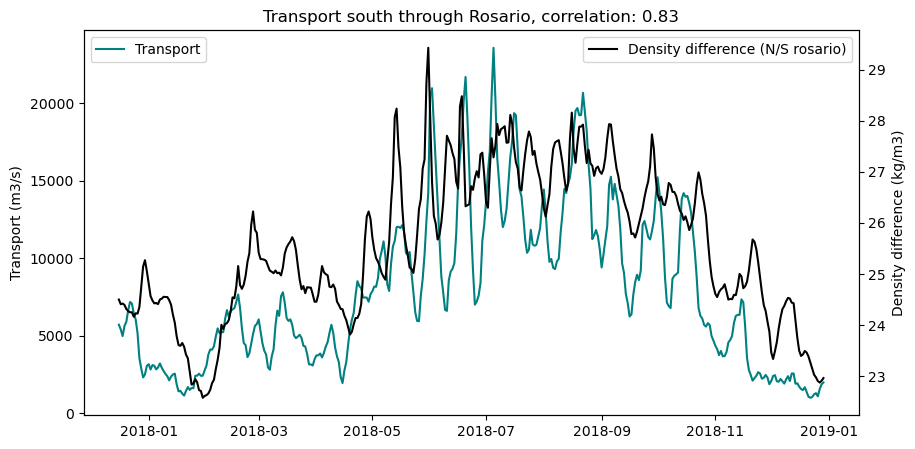

In [25]:
rostosouth = PRtovs_ros_avg + PRtoadm_ros_avg
date_rossh = list(rostosouth.dropna().index)

mask = np.isin(datelist_dens,date_rossh)
densdiff_ros = dens_diff_ros[mask]
densdiff_ros2 = dens_diff_rosVS[mask]
date_dens_sh = np.array(datelist_dens)[mask]

corr_rostosouth,p = stats.spearmanr(densdiff_ros,rostosouth.dropna())
print(corr_rostosouth)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_sh,densdiff_ros,color='k',label='Density difference (N/S rosario)')
ax.set_title(f'Transport south through Rosario, correlation: {np.round(corr_rostosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

In [26]:
rostosouth.dropna()

2017-12-16    5717.056867
2017-12-17    5410.744930
2017-12-18    4982.965563
2017-12-19    5634.886245
2017-12-20    5908.381155
                 ...     
2018-12-25    1305.061622
2018-12-26    1100.395288
2018-12-27    1563.614370
2018-12-28    1874.142372
2018-12-29    1986.504325
Name: Transport, Length: 379, dtype: float64

2750.351224256408 -62426.847692377734


Text(0.5, 1.0, 'corr = -0.124')

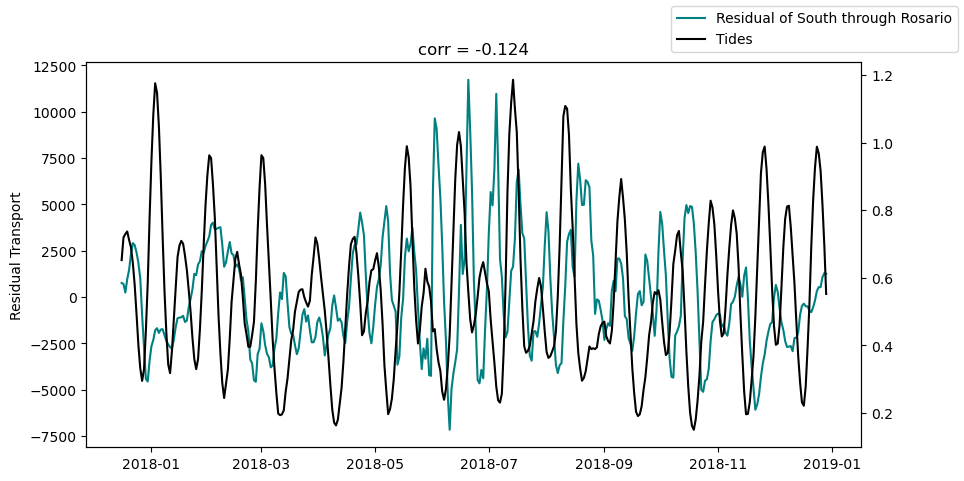

In [27]:
slope,intercept = np.polyfit(densdiff_ros,rostosouth.dropna(),1)
ddline = slope*densdiff_ros+intercept
res = rostosouth.dropna() - ddline
print(slope,intercept)

slope,intercept = np.polyfit(densdiff_ros2,rostosouth.dropna(),1)
ddline2 = slope*densdiff_ros2+intercept
res_ros2 = rostosouth.dropna() - ddline2

mask = np.isin(datelist_tides,date_rossh)
date_tides_sh = np.array(datelist_tides)[mask]
tides_sh = tides.vozocrtx[mask]

corr,p = stats.spearmanr(tides_sh,res)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='k',label='Tides')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')

In [28]:
tides_sh

349    0.652360
350    0.719330
351    0.729538
352    0.737048
353    0.712057
         ...   
723    0.968160
724    0.916849
725    0.817718
726    0.696821
727    0.552249
Name: vozocrtx, Length: 379, dtype: float64

Text(0.5, 1.0, 'corr = -0.196')

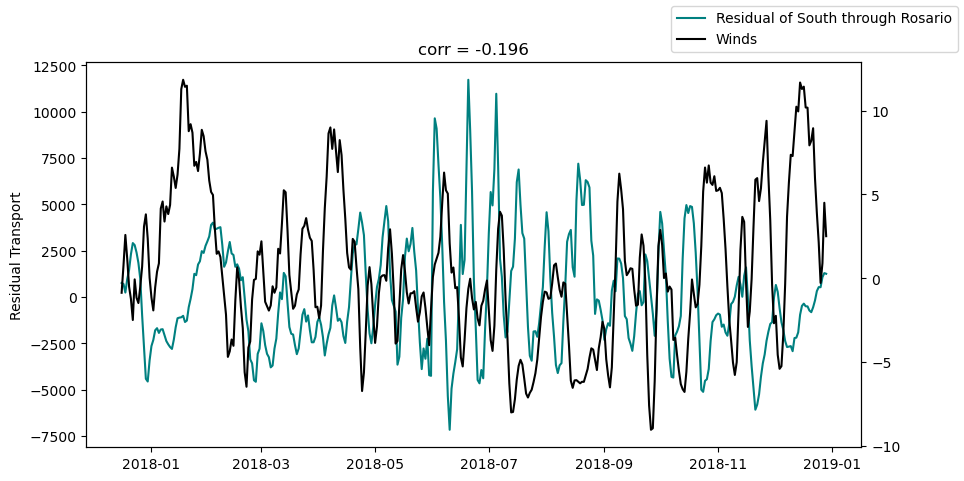

In [29]:
mask = np.isin(datelist_winds,date_rossh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_sh = y_mean4[mask]

corr,p = stats.spearmanr(winds_sh,res)
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_winds_sh,winds_sh,color='k',label='Winds')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')

### Through Haro

Now need:
- PR to adm
- PR to VS
- Gulf to adm
- Gulf to VS

4 and then combine them as before

#### PR to VicSill

In [30]:
PRtovs_harol = sectransp_2018['forpr_haro3'][6]
PRtovs_harobl = sectransp_2018['backvs_haro3'][6]

PRtovs_haro = pd.Series(PRtovs_harol,index=datelist_vs)
PRtovs_harob = pd.Series(PRtovs_harobl,index=datelist_vs)

In [31]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_haro,age_2018['forpr_haro3'][6],datelist_vs,base,factor)
        dfr2 = shift_time(PRtovs_harob,age_2018['backvs_haro3'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.66:
            print (base, factor, corr_arr[i, j])

In [32]:
i_base_vs_haro,i_factor_vs_haro = np.where(corr_arr==np.max(corr_arr))

base_vs_haro = base_arr[i_base_vs_haro]
factor_vs_haro = factor_arr[i_factor_vs_haro]

print(base_vs_haro,factor_vs_haro)

[-1.] [0.25]


0.6500878906980782


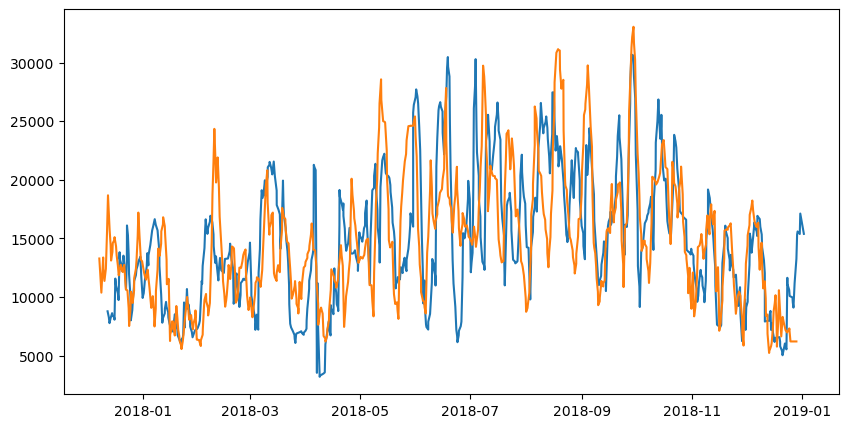

In [33]:
PRtovs_haro_sh = shift_time(PRtovs_haro,age_2018['forpr_haro3'][5],datelist_vs,base_vs_haro[0],factor_vs_haro[0])
PRtovs_harob_sh = shift_time(PRtovs_harob,age_2018['backvs_haro3'][6],datelist_vs,-base_vs_haro[0],-factor_vs_haro[0])

PRtovs_haro_m,PRtovs_harob_m,c,PRtovs_haro_avg = merge(PRtovs_haro_sh,PRtovs_harob_sh)
print(c)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(PRtovs_haro_m.Transport)
ax.plot(PRtovs_harob_m.Transport)

Why do these 2 look so different????

#### PR to adm

In [34]:
PRtoadm_harol = sectransp_2018['forpr_haro3'][2]
PRtoadm_harobl = sectransp_2018['backadm_haro3'][6]

PRtoadm_haro = pd.Series(PRtoadm_harol,index=datelist_vs)
PRtoadm_harob = pd.Series(PRtoadm_harobl,index=datelist_vs)

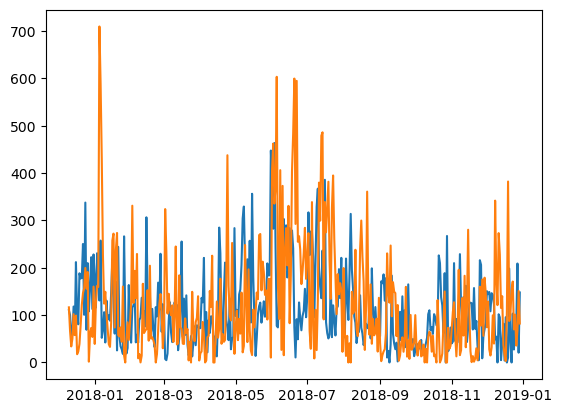

In [35]:
plt.plot(PRtoadm_haro)
plt.plot(PRtoadm_harob)

These is essentially insignificant when comparing to whats going to VicSill -> ignore PR to VS

#### Gulf to VicSill

In [36]:
Gulftovs_harol = sectransp_2018['forgulf_haro3'][7]
Gulftovs_harobl = sectransp_2018['backvs_haro3'][7]

Gulftovs_haro = pd.Series(Gulftovs_harol,index=datelist_vs)
Gulftovs_harob = pd.Series(Gulftovs_harobl,index=datelist_vs)

In [37]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(Gulftovs_haro,age_2018['forgulf_haro3'][7],datelist_vs,base,factor)
        dfr2 = shift_time(Gulftovs_harob,age_2018['backvs_haro3'][7],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.69:
            print (base, factor, corr_arr[i, j])

0.8500000000000016 0.30000000000000115 0.6991381566103212
0.9000000000000017 0.30000000000000115 0.6965035292890257
0.9500000000000017 0.30000000000000115 0.6935192413846839


In [38]:
i_base_gulfvs_haro,i_factor_gulfvs_haro = np.where(corr_arr==np.max(corr_arr))

base_gulfvs_haro = base_arr[i_base_gulfvs_haro]
factor_gulfvs_haro = factor_arr[i_factor_gulfvs_haro]

print(base_gulfvs_haro,factor_gulfvs_haro)

[0.85] [0.3]


0.4067090362813058


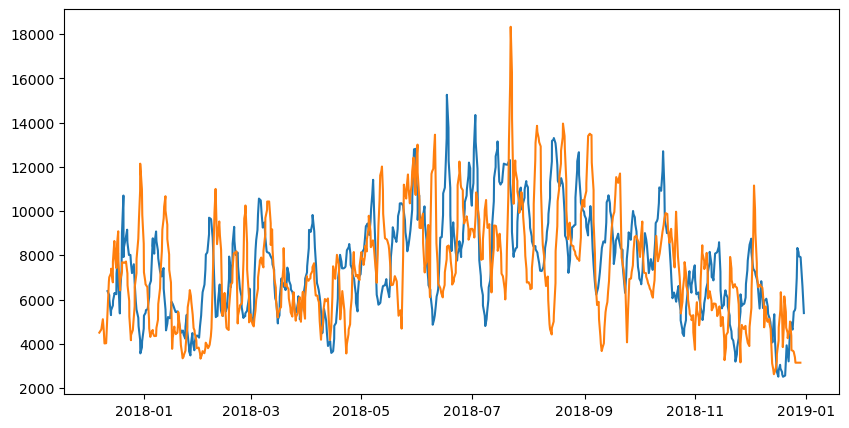

In [39]:
Gulftovs_haro_sh = shift_time(Gulftovs_haro,age_2018['forgulf_haro3'][7],datelist_vs,base_vs_haro[0],factor_vs_haro[0])
Gulftovs_harob_sh = shift_time(Gulftovs_harob,age_2018['backvs_haro3'][7],datelist_vs,-base_vs_haro[0],-factor_vs_haro[0])

Gulftovs_haro_m,Gulftovs_harob_m,c,Gulftovs_haro_avg = merge(Gulftovs_haro_sh,Gulftovs_harob_sh)
print(c)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(Gulftovs_haro_m.Transport)
ax.plot(Gulftovs_harob_m.Transport)

Gulf to VicSill more significnt than PointRob to VicSill

#### Gulf to adm

In [40]:
Gulftoadm_harol = sectransp_2018['forgulf_haro3'][2]
Gulftoadm_harobl = sectransp_2018['backadm_haro3'][7]

Gulftoadm_haro = pd.Series(Gulftoadm_harol,index=datelist_vs)
Gulftoadm_harob = pd.Series(Gulftoadm_harobl,index=datelist_vs)

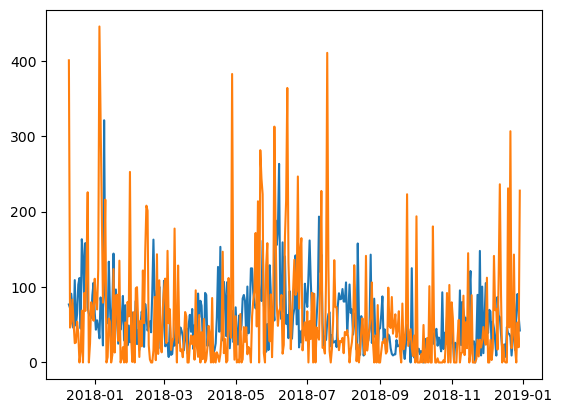

In [41]:
plt.plot(Gulftoadm_haro)
plt.plot(Gulftoadm_harob)

Gulf to admiralty also basically insignificant

Text(0, 0.5, 'Transport (m3/s)')

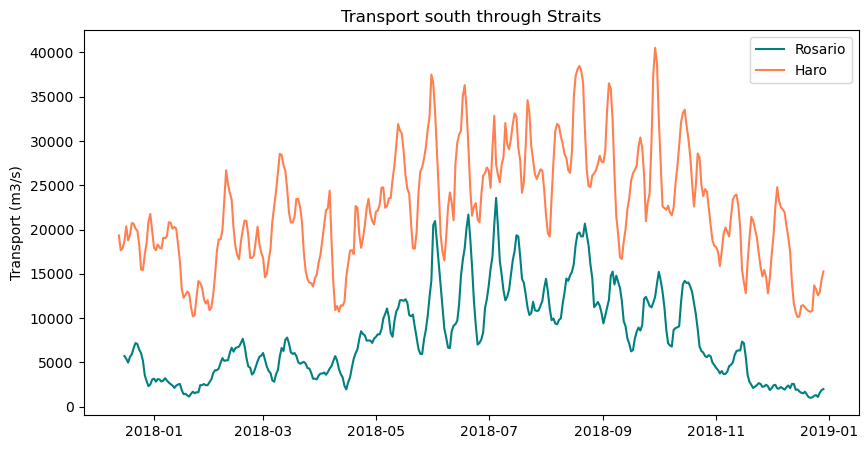

In [42]:
harotosouth = PRtovs_haro_avg + Gulftovs_haro_avg
date_harosh = list(harotosouth.dropna().index)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna(),label='Rosario',color='teal')
ax.plot(harotosouth.dropna(),label='Haro',color='coral')
ax.legend()
ax.set_title(f'Transport south through Straits')
ax.set_ylabel('Transport (m3/s)')

In [43]:
corr_haroros,p = stats.spearmanr(rostosouth.dropna(),harotosouth.dropna()[3:])
print(corr_haroros)

0.7771471334448699


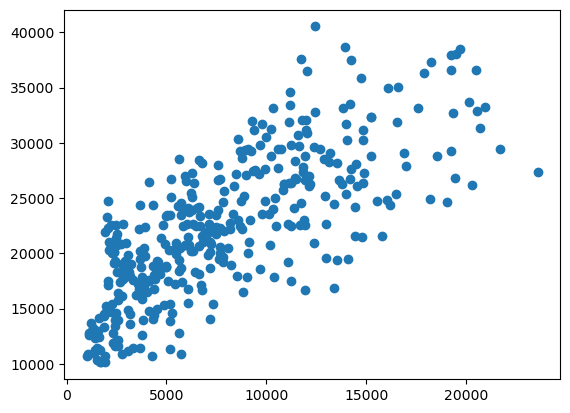

In [44]:
plt.scatter(rostosouth.dropna(),harotosouth.dropna()[3:])

#### Correlations with transport south through Haro

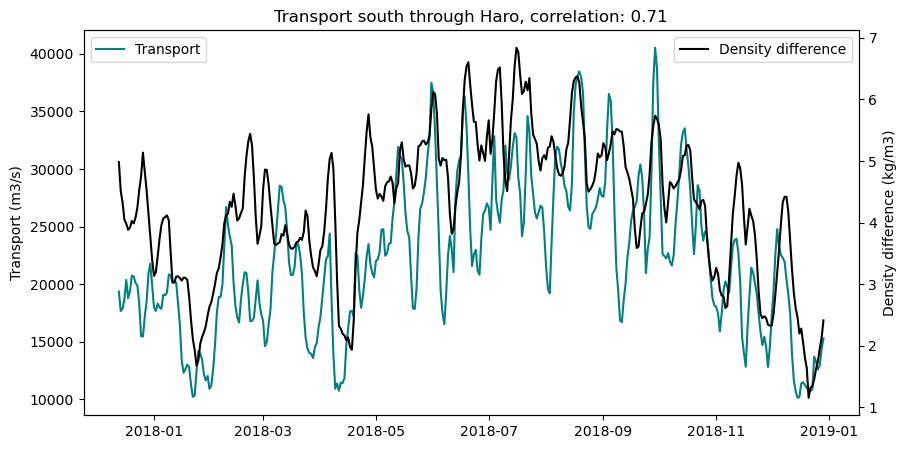

In [45]:
date_harosh = list(harotosouth.dropna().index)

mask = np.isin(datelist_dens,date_harosh)
densdiff_haro = dens_diff_haro[mask]
date_dens_haro_sh = np.array(datelist_dens)[mask]

corr_harotosouth,p = stats.spearmanr(densdiff_haro,harotosouth.dropna())

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_haro_sh,densdiff_haro,color='k',label='Density difference')
ax.set_title(f'Transport south through Haro, correlation: {np.round(corr_harotosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

Find density difference N/S through Haro to increase this correlation?

In [46]:
len(rostosouth.dropna())

379

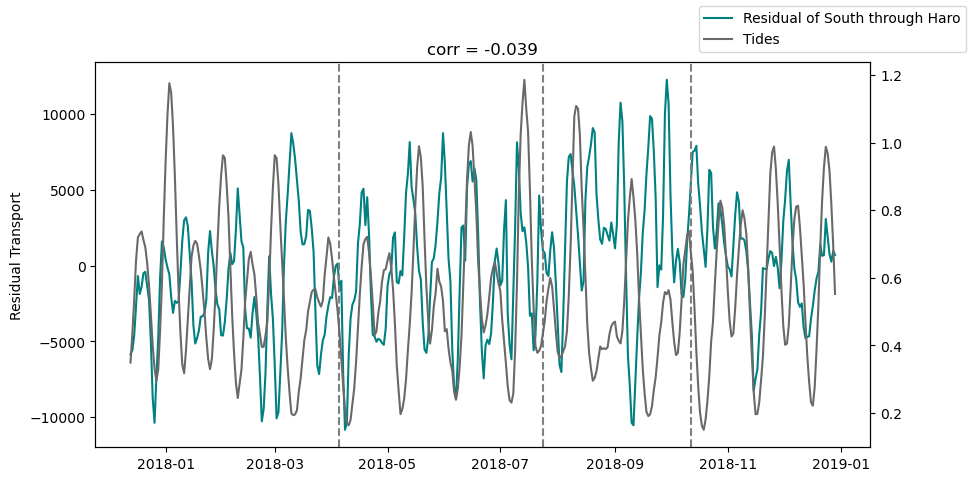

In [47]:
slope,intercept = np.polyfit(densdiff_haro,harotosouth.dropna(),1)
ddline_haro = slope*densdiff_haro+intercept
res_haro = harotosouth.dropna() - ddline_haro

mask = np.isin(datelist_tides,date_harosh)
date_tides_haro_sh = np.array(datelist_tides)[mask]
tides_haro_sh = tides.vozocrtx[mask]

corr,p = stats.spearmanr(tides_haro_sh,res_haro)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro,color='teal',label='Residual of South through Haro')
ax2 = ax.twinx()
ax2.plot(date_tides_haro_sh,tides_haro_sh,color='dimgrey',label='Tides')
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
# ax.plot(rostosouth.dropna(),label='Transport south through Rosario')
# ax.plot(res,label='Residual south through Rosario',color='darkblue')
ax.axvline(date_tides_sh[110],ls='--',color='grey')
ax.axvline(date_tides_sh[220],ls='--',color='grey')
ax.axvline(date_tides_sh[300],ls='--',color='grey')
# ax3 = ax.twinx()
# ax3.plot(date_winds_sh,winds_sh,color='darkgrey',label='Winds')
# ax3.spines['right'].set_position(('outward', 80))
fig.legend()

Text(0, 0.5, 'Wind velocity')

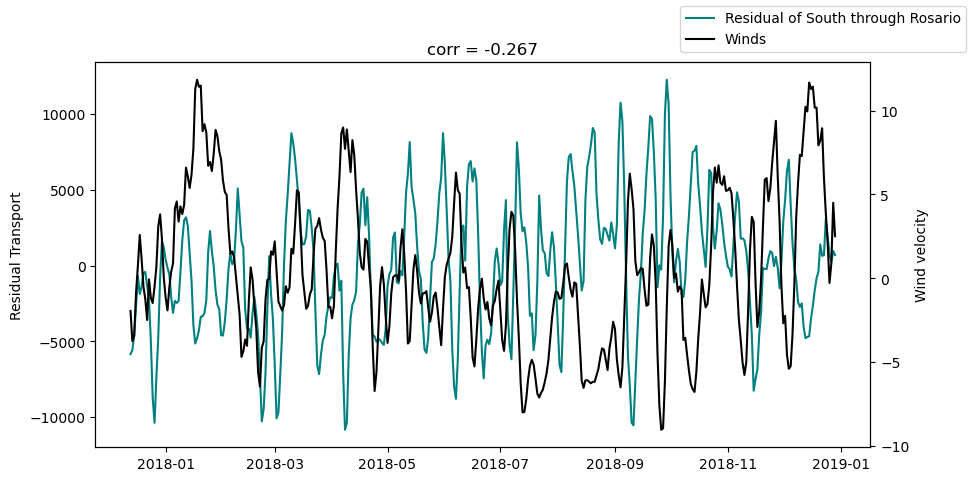

In [49]:
mask = np.isin(datelist_winds,date_harosh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_haro = y_mean4[mask]

corr,p = stats.spearmanr(winds_haro,res_haro)
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_winds_sh,winds_haro,color='k',label='Winds')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
ax2.set_ylabel('Wind velocity')

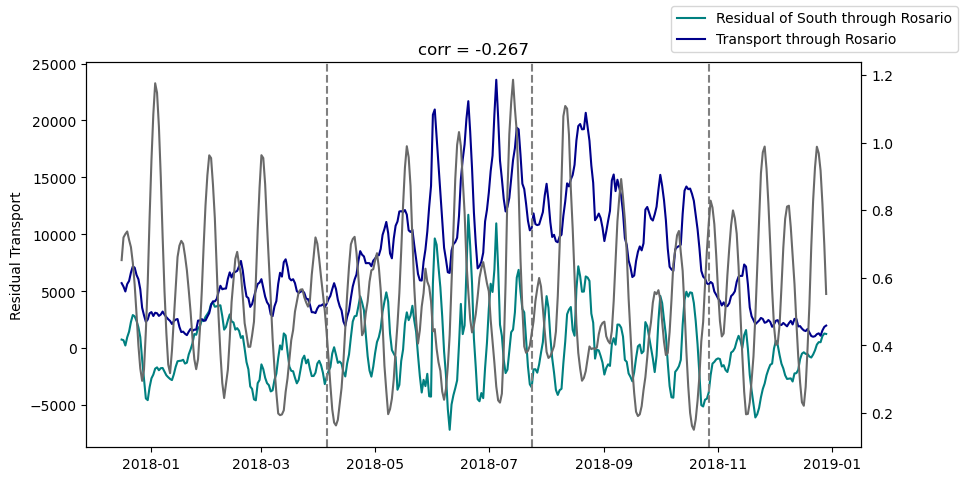

In [50]:
corr,p = stats.spearmanr(winds_haro,res_haro)
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='dimgrey')
ax.plot(rostosouth.dropna(),color='darkblue',label='Transport through Rosario')
# ax.plot(harotosouth.dropna(),color='sienna',label='Transport through Haro')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
ax.axvline(date_tides_sh[110],ls='--',color='grey')
ax.axvline(date_tides_sh[220],ls='--',color='grey')
ax.axvline(date_tides_sh[315],ls='--',color='grey')

Look at correlation in zone 2 of tides with residual Rosario transport. Zone 2 looks like its better (inversely) correlated with the tides than the others

In [51]:
print(f'\n ---- Overall ---- \n')

corr,p = stats.spearmanr(tides_haro_sh,res_haro)
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro,res_haro)
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh,res)
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh,res)
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[3:],rostosouth.dropna())
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh,winds_sh)
print('Tides and Winds (Ros):',corr6)
corr7,p = stats.spearmanr(tides_haro_sh,winds_haro)
print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 1 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[23:113],res_haro[23:113])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[23:113],res_haro[23:113])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[20:110],res[20:110])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[20:110],res[20:110])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[23:113],rostosouth.dropna()[20:110])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[20:110],winds_sh[20:110])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[23:113],winds_haro[23:113])
# print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 2 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[113:223],res_haro[113:223])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[113:223],res_haro[113:223])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[110:220],res[110:220])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[110:220],res[110:220])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[113:223],rostosouth.dropna()[110:220])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[110:220],winds_sh[110:220])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[113:223],winds_haro[113:223])
# print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 3 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[223:303],res_haro[223:303])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[223:303],res_haro[223:303])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[220:300],res[220:300])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[220:300],res[220:300])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[223:303],rostosouth.dropna()[220:300])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[220:300],winds_sh[220:300])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[223:303],winds_haro[223:303])
# print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 4 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[303:],res_haro[303:])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[303:],res_haro[303:])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[300:],res[300:])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[300:],res[300:])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[303:],rostosouth.dropna()[300:])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[300:],winds_sh[300:])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[303:],winds_haro[303:])
# print('Tides and Winds (Haro):',corr7)


 ---- Overall ---- 

Tides and Haro: -0.03924564963670685
Winds and Haro: -0.26702647056955703
Tides and Ros -0.12447301190531297
Winds and Ros: -0.19575566003839853
Haro and Ros: 0.7771471334448699
Tides and Winds (Ros): -0.015833559271970606
Tides and Winds (Haro): -0.0120649946165038

 ---- ZONE 1 ---- 

Tides and Haro: -0.6257151088611762
Winds and Haro: 0.010939622175577233
Tides and Ros 0.002131950446557188
Winds and Ros: 0.22197802197802197
Haro and Ros: 0.5911100135819236
Tides and Winds (Ros): 0.1395480923570811

 ---- ZONE 2 ---- 

Tides and Haro: 0.42195072470301825
Winds and Haro: -0.2575073822780245
Tides and Ros -0.031724635394360164
Winds and Ros: -0.10798638505060525
Haro and Ros: 0.7135270382976805
Tides and Winds (Ros): -0.489818091652954

 ---- ZONE 3 ---- 

Tides and Haro: -0.3052273792780122
Winds and Haro: -0.22405063291139243
Tides and Ros -0.20459446788560715
Winds and Ros: -0.106516643225504
Haro and Ros: 0.2870839193624004
Tides and Winds (Ros): 0.11371308016

In [52]:
res

2017-12-16     758.383254
2017-12-17     702.306940
2017-12-18     238.485388
2017-12-19     964.032843
2017-12-20    1457.063885
                 ...     
2018-12-25     532.205708
2018-12-26     527.061891
2018-12-27    1067.969479
2018-12-28    1288.356515
2018-12-29    1253.069259
Name: Transport, Length: 379, dtype: float64

In [53]:
print(f'\n ---- Overall ---- \n')

corr,p = stats.spearmanr(tides_haro_sh,res_haro)
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro,res_haro)
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh,res)
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh,res)
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[3:],rostosouth.dropna())
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh,winds_sh)
print('Tides and Winds (Ros):',corr6)
corr7,p = stats.spearmanr(tides_haro_sh,winds_haro)
print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 1 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[23:113],res_haro[23:113])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[23:113],res_haro[23:113])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[20:110],res[20:110])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[20:110],res[20:110])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[23:113],rostosouth.dropna()[20:110])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[20:110],winds_sh[20:110])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[23:113],winds_haro[23:113])
# print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 2 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[113:223],res_haro[113:223])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[113:223],res_haro[113:223])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[110:220],res[110:220])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[110:220],res[110:220])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[113:223],rostosouth.dropna()[110:220])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[110:220],winds_sh[110:220])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[113:223],winds_haro[113:223])
# print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 3 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[223:303],res_haro[223:303])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[223:303],res_haro[223:303])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[220:300],res[220:300])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[220:300],res[220:300])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[223:303],rostosouth.dropna()[220:300])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[220:300],winds_sh[220:300])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[223:303],winds_haro[223:303])
# print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 4 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[303:368],res_haro[303:368])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[303:368],res_haro[303:368])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[300:365],res[300:365])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[300:365],res[300:365])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[303:368],rostosouth.dropna()[300:365])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[300:365],winds_sh[300:365])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[303:],winds_haro[303:])
# print('Tides and Winds (Haro):',corr7)


 ---- Overall ---- 

Tides and Haro: -0.03924564963670685
Winds and Haro: -0.26702647056955703
Tides and Ros -0.12447301190531297
Winds and Ros: -0.19575566003839853
Haro and Ros: 0.7771471334448699
Tides and Winds (Ros): -0.015833559271970606
Tides and Winds (Haro): -0.0120649946165038

 ---- ZONE 1 ---- 

Tides and Haro: -0.6257151088611762
Winds and Haro: 0.010939622175577233
Tides and Ros 0.002131950446557188
Winds and Ros: 0.22197802197802197
Haro and Ros: 0.5911100135819236
Tides and Winds (Ros): 0.1395480923570811

 ---- ZONE 2 ---- 

Tides and Haro: 0.42195072470301825
Winds and Haro: -0.2575073822780245
Tides and Ros -0.031724635394360164
Winds and Ros: -0.10798638505060525
Haro and Ros: 0.7135270382976805
Tides and Winds (Ros): -0.489818091652954

 ---- ZONE 3 ---- 

Tides and Haro: -0.3052273792780122
Winds and Haro: -0.22405063291139243
Tides and Ros -0.20459446788560715
Winds and Ros: -0.106516643225504
Haro and Ros: 0.2870839193624004
Tides and Winds (Ros): 0.11371308016

In [54]:
print(f'\n ---- Overall ---- \n')

corr,p = stats.spearmanr(tides_haro_sh,res_haro)
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro,res_haro)
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh,res)
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh,res)
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[3:],rostosouth.dropna())
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh,winds_sh)
print('Tides and Winds (Ros):',corr6)
corr7,p = stats.spearmanr(tides_haro_sh,winds_haro)
print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 1 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[23:113],res_haro[23:113])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[23:113],res_haro[23:113])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[20:110],res[20:110])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[20:110],res[20:110])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[23:113],rostosouth.dropna()[20:110])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[20:110],winds_sh[20:110])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[23:113],winds_haro[23:113])
# print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 2 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[113:223],res_haro[113:223])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[113:223],res_haro[113:223])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[110:220],res[110:220])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[110:220],res[110:220])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[113:223],rostosouth.dropna()[110:220])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[110:220],winds_sh[110:220])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[113:223],winds_haro[113:223])
# print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 3 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[223:303],res_haro[223:303])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[223:303],res_haro[223:303])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[220:300],res[220:300])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[220:300],res[220:300])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[223:303],rostosouth.dropna()[220:300])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[220:300],winds_sh[220:300])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[223:303],winds_haro[223:303])
# print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 4 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[303:],res_haro[303:])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[303:],res_haro[303:])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[300:],res[300:])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[300:],res[300:])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[303:],rostosouth.dropna()[300:])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[300:],winds_sh[300:])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[303:],winds_haro[303:])
# print('Tides and Winds (Haro):',corr7)


 ---- Overall ---- 

Tides and Haro: -0.03924564963670685
Winds and Haro: -0.26702647056955703
Tides and Ros -0.12447301190531297
Winds and Ros: -0.19575566003839853
Haro and Ros: 0.7771471334448699
Tides and Winds (Ros): -0.015833559271970606
Tides and Winds (Haro): -0.0120649946165038

 ---- ZONE 1 ---- 

Tides and Haro: -0.6257151088611762
Winds and Haro: 0.010939622175577233
Tides and Ros 0.002131950446557188
Winds and Ros: 0.22197802197802197
Haro and Ros: 0.5911100135819236
Tides and Winds (Ros): 0.1395480923570811

 ---- ZONE 2 ---- 

Tides and Haro: 0.42195072470301825
Winds and Haro: -0.2575073822780245
Tides and Ros -0.031724635394360164
Winds and Ros: -0.10798638505060525
Haro and Ros: 0.7135270382976805
Tides and Winds (Ros): -0.489818091652954

 ---- ZONE 3 ---- 

Tides and Haro: -0.3052273792780122
Winds and Haro: -0.22405063291139243
Tides and Ros -0.20459446788560715
Winds and Ros: -0.106516643225504
Haro and Ros: 0.2870839193624004
Tides and Winds (Ros): 0.11371308016

In [55]:
len(date_tides_sh),len(tides_sh)
date_tides_haro_sh

array([datetime.datetime(2017, 12, 13, 0, 0),
       datetime.datetime(2017, 12, 14, 0, 0),
       datetime.datetime(2017, 12, 15, 0, 0),
       datetime.datetime(2017, 12, 16, 0, 0),
       datetime.datetime(2017, 12, 17, 0, 0),
       datetime.datetime(2017, 12, 18, 0, 0),
       datetime.datetime(2017, 12, 19, 0, 0),
       datetime.datetime(2017, 12, 20, 0, 0),
       datetime.datetime(2017, 12, 21, 0, 0),
       datetime.datetime(2017, 12, 22, 0, 0),
       datetime.datetime(2017, 12, 23, 0, 0),
       datetime.datetime(2017, 12, 24, 0, 0),
       datetime.datetime(2017, 12, 25, 0, 0),
       datetime.datetime(2017, 12, 26, 0, 0),
       datetime.datetime(2017, 12, 27, 0, 0),
       datetime.datetime(2017, 12, 28, 0, 0),
       datetime.datetime(2017, 12, 29, 0, 0),
       datetime.datetime(2017, 12, 30, 0, 0),
       datetime.datetime(2017, 12, 31, 0, 0),
       datetime.datetime(2018, 1, 1, 0, 0),
       datetime.datetime(2018, 1, 2, 0, 0),
       datetime.datetime(2018, 1, 3, 0

#### Split into sub regions to check correlation

-0.6559774964838256
0.006891701828410689
-0.1951945616502579
Correlation with res ros and tides: -0.06085325832161276
-0.058321612751992505
-0.12447301190531297


Text(0.5, 1.0, 'Correlation: -0.656')

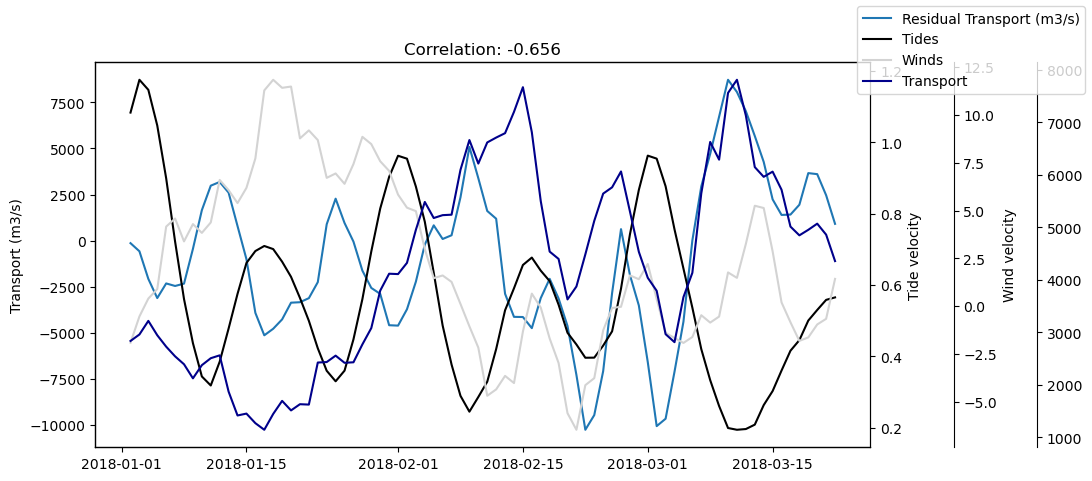

In [56]:
aa = date_tides_haro_sh[20:100]
aaa = date_tides_sh[20:100]
a = res_haro[20:100]
b = tides_haro_sh[20:100]
c = winds_haro[20:100]
d = rostosouth.dropna()[20:100]
e = res[20:100]
f = res_ros2[20:100]
bb = tides_sh[20:100]

corr1,p = stats.spearmanr(a,b)
print(corr1)

corr2,p = stats.spearmanr(a,c)
print(corr2)

corr3,p = stats.spearmanr(bb,d)
print(corr3)

corr4,p = stats.spearmanr(b,e)
print('Correlation with res ros and tides:',corr4)

corr5,p = stats.spearmanr(b,f)
print(corr5)

corr6,p = stats.spearmanr(tides_sh,res)
print(corr6)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(aa,a,label='Residual Transport (m3/s)')
ax2 = ax.twinx()
ax2.plot(aa,b,color='k',label='Tides')
ax3 = ax.twinx()
ax3.plot(aa,c,color='lightgrey',label='Winds')
ax3.spines['right'].set_position(('outward', 60))
ax4 = ax.twinx()
ax4.plot(aa,d,color='darkblue',label='Transport')
ax4.spines['right'].set_position(('outward', 120))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Wind velocity')
fig.legend()
ax.set_title(f'Correlation: {np.round(corr1,3)}')

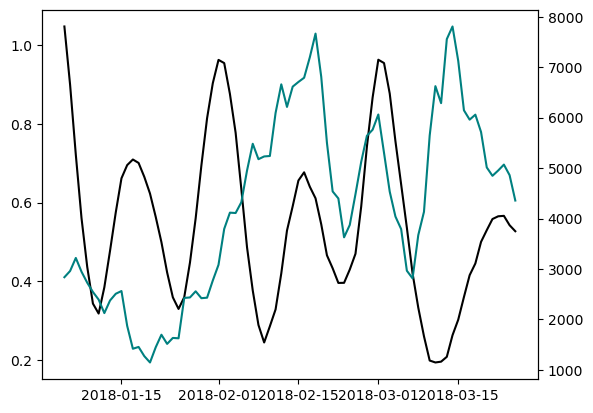

In [57]:
fig,ax = plt.subplots()

ax.plot(aaa,bb,color='k')
ax2 = ax.twinx()
ax2.plot(d,color='teal')

Look at the correlation with density difference b/w VicSill and PR (vs. N/S of Rosario)

**High correlation of transport to the wind (likely because the wind and density difference are highly correlated) - residual high correlation with the tides and very low with the winds

0.42195072470301825
-0.2575073822780245
-0.031724635394360164
0.17205779591100692
-0.05127245677704393


Text(0.5, 1.0, 'Zone 2: Correlation: 0.422')

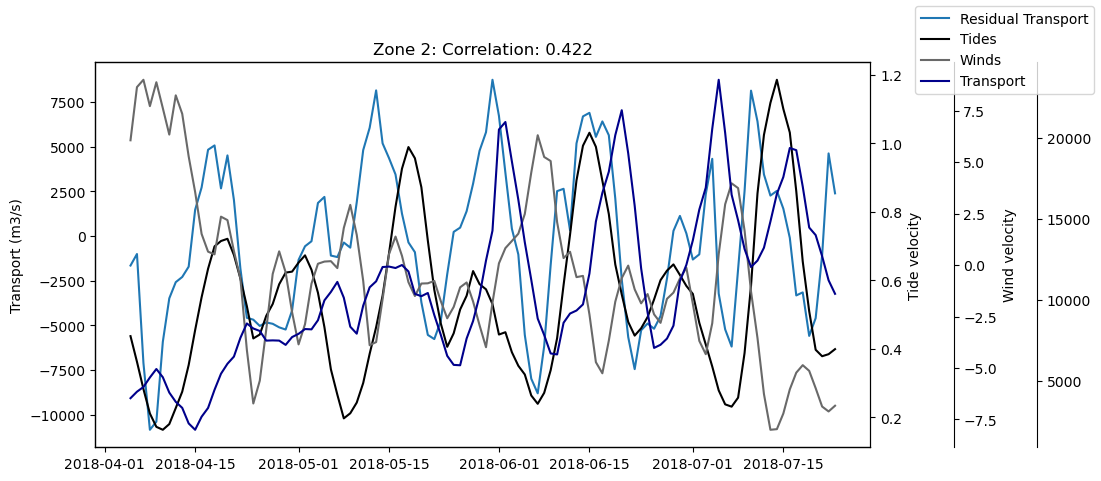

In [58]:
aa = date_tides_sh[110:220]
a = res_haro[113:223]
b = tides_sh[110:220]
c = winds_sh[110:220]
d = rostosouth.dropna()[110:220]
e = res[110:220]
f = res_ros2[110:220]

corr1,p = stats.spearmanr(a,b)
print(corr1)
corr2,p = stats.spearmanr(a,c)
print(corr2)
corr3,p = stats.spearmanr(b,e)
print(corr3)
corr4,p = stats.spearmanr(b,d)
print(corr4)
corr5,p = stats.spearmanr(b,f)
print(corr5)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(aa,a,label='Residual Transport')
ax2 = ax.twinx()
ax2.plot(aa,b,color='k',label='Tides')
ax3 = ax.twinx()
ax3.plot(aa,c,color='dimgrey',label='Winds')
ax3.spines['right'].set_position(('outward', 60))
ax4 = ax.twinx()
ax4.plot(aa,d,color='darkblue',label='Transport')
ax4.spines['right'].set_position(('outward', 120))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Wind velocity')
fig.legend()
ax.set_title(f'Zone 2: Correlation: {np.round(corr1,3)}')

Correlation with residual rosTsouth is high... but positive. Even higher than through Haro.

If we look at density difference from Rosario to PR its higher ... So stick with this
(try from PR to VS?) - How to tell which density difference I'm even looking at ?? IDK that's my fault

-0.25662684078910813
0.026229508196721315
0.05907196443456518
-0.13303695470964158


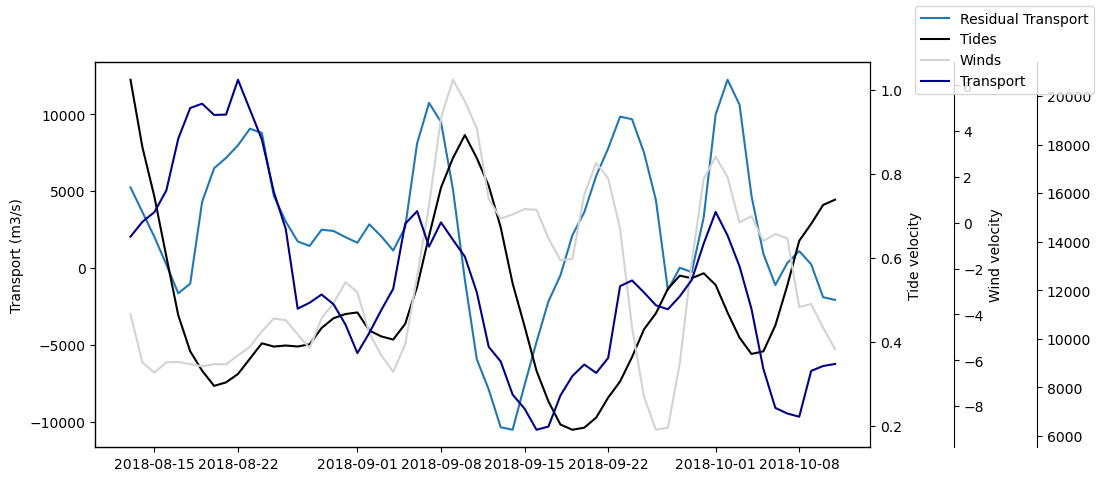

In [59]:
aa = date_tides_sh[240:300]
a = res_haro[240:300]
b = tides_sh[240:300]
c = winds_sh[240:300]
d = rostosouth.dropna()[240:300]
e = res[240:300]

corr1,p = stats.spearmanr(a,b)
print(corr1)
corr2,p = stats.spearmanr(a,c)
print(corr2)
corr3,p = stats.spearmanr(b,d)
print(corr3)
corr4,p = stats.spearmanr(b,e)
print(corr4)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(aa,a,label='Residual Transport')
ax2 = ax.twinx()
ax2.plot(aa,b,color='k',label='Tides')
ax3 = ax.twinx()
ax3.plot(aa,c,color='lightgrey',label='Winds')
ax3.spines['right'].set_position(('outward', 60))
ax4 = ax.twinx()
ax4.plot(aa,d,color='darkblue',label='Transport')
ax4.spines['right'].set_position(('outward', 120))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Wind velocity')
fig.legend()

0.16628529698149952
-0.5323028237585199
-0.3643378773125609
-0.29790652385589095
-0.4677458617332035


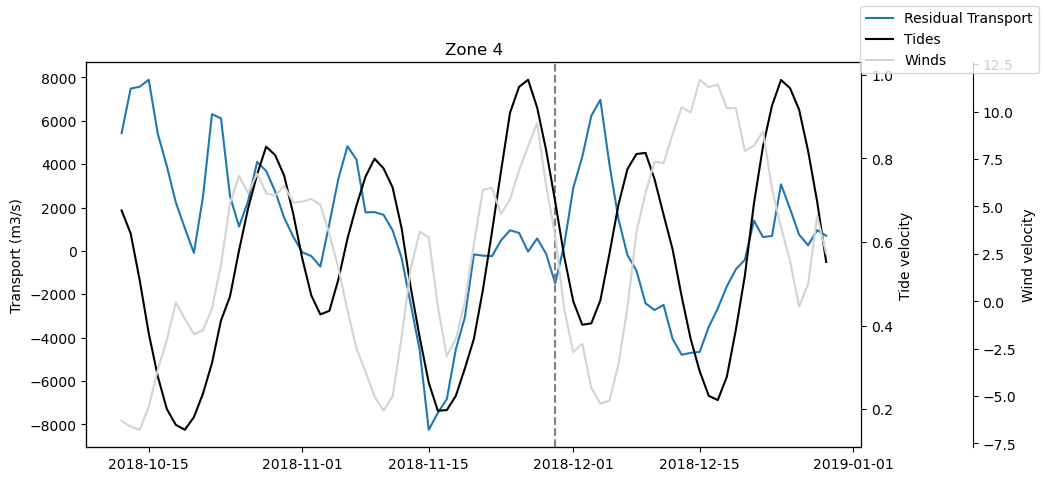

In [60]:
aa = date_tides_sh[300:]
a = res_haro[303:]
b = tides_sh[300:]
c = winds_haro[303:]
d = rostosouth.dropna()[300:]
e = res[300:]

corr1,p = stats.spearmanr(a,b)
print(corr1)
corr2,p = stats.spearmanr(a,c)
print(corr2)
corr3,p = stats.spearmanr(b,d)
print(corr3)
corr4,p = stats.spearmanr(b,e)
print(corr4)
corr5,p = stats.spearmanr(c,d)
print(corr5)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(aa,a,label='Residual Transport')
ax2 = ax.twinx()
ax2.plot(aa,b,color='k',label='Tides')
ax3 = ax.twinx()
ax3.plot(aa,c,color='lightgrey',label='Winds')
ax3.spines['right'].set_position(('outward', 80))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Wind velocity')
fig.legend()
ax.set_title('Zone 4')
ax.axvline(date_tides_sh[348],ls='--',color='grey')

#### Additional Zone 4 Analysis

Try these 2 ^^ subregions

0.16825879287885367
-0.3054711246200608
-0.5140034737299175
-0.4077290490664351
-0.556665219279201


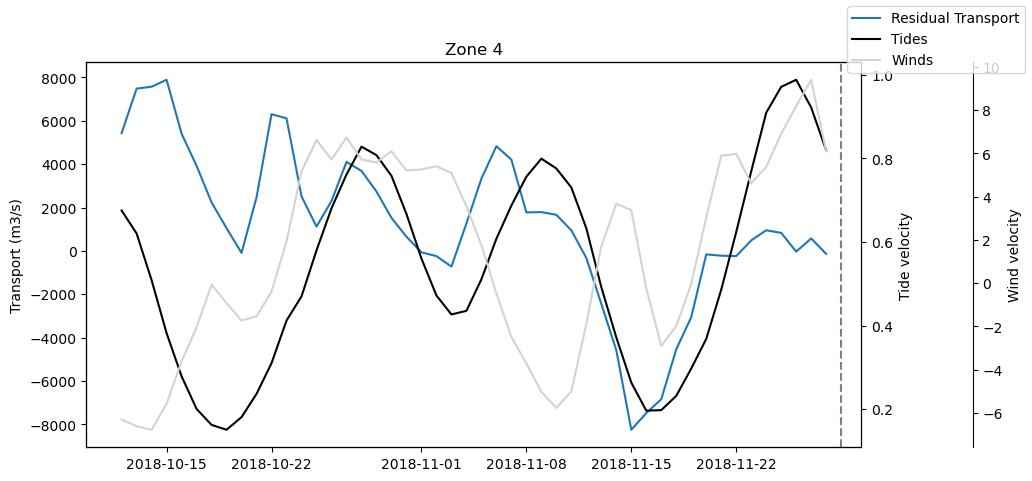

In [61]:
aa = date_tides_sh[300:348]
a = res_haro[303:351]
b = tides_sh[300:348]
c = winds_haro[303:351]
d = rostosouth.dropna()[300:348]
e = res[300:348]

corr1,p = stats.spearmanr(a,b)
print(corr1)
corr2,p = stats.spearmanr(a,c)
print(corr2)
corr3,p = stats.spearmanr(b,d)
print(corr3)
corr4,p = stats.spearmanr(b,e)
print(corr4)
corr5,p = stats.spearmanr(c,d)
print(corr5)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(aa,a,label='Residual Transport')
ax2 = ax.twinx()
ax2.plot(aa,b,color='k',label='Tides')
ax3 = ax.twinx()
ax3.plot(aa,c,color='lightgrey',label='Winds')
ax3.spines['right'].set_position(('outward', 80))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Wind velocity')
fig.legend()
ax.set_title('Zone 4')
ax.axvline(date_tides_sh[348],ls='--',color='grey')

This increased negative correlation with winds -> Calculate residual of rosario and haro after winds

In [62]:
slope,intercept = np.polyfit(winds_haro[303:351],res_haro[303:351],1)
wind_line_haro = slope*winds_haro[303:351]+intercept
res_haro_wind = res_haro[303:351].values - wind_line_haro

corr,p = stats.spearmanr(tides_haro_sh[303:351],res_haro_wind)
print(corr)

slope,intercept = np.polyfit(winds_sh[300:348],res[300:348],1)
wind_line_ros = slope*winds_sh[300:348]+intercept
res_ros_wind = res[300:348].values - wind_line_ros

corr,p = stats.spearmanr(tides_sh[300:348],res_ros_wind)
print(corr)

0.26194094659140255
-0.25


Text(0, 0.5, 'Tide velocity ')

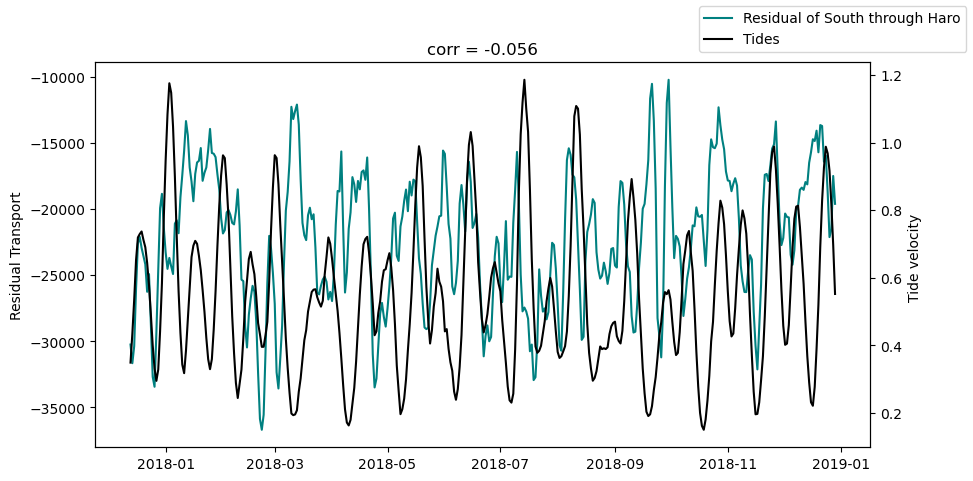

In [63]:
slope,intercept = np.polyfit(winds_haro,harotosouth.dropna(),1)
wline_haro = slope*winds_haro+intercept
resw_haro = res_haro.values - wline_haro

mask = np.isin(datelist_tides,date_winds_sh)
date_tides_sh = np.array(datelist_tides)[mask]
tides_sh = tides.vozocrtx[mask]

corr,p = stats.spearmanr(tides_sh,resw_haro)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(date_tides_sh,resw_haro,color='teal',label='Residual of South through Haro')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='k',label='Tides')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
ax2.set_ylabel('Tide velocity ')

-0.1242582825274737


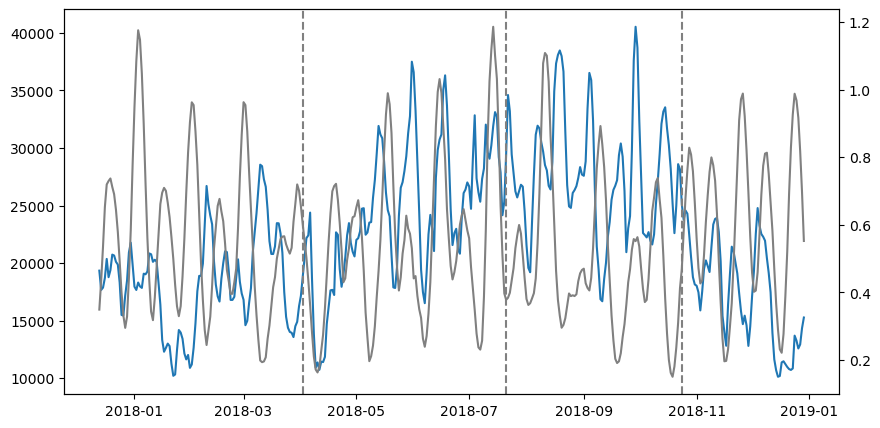

In [64]:
corr,p = stats.spearmanr(tides_haro_sh,harotosouth.dropna())
print(corr)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotosouth.dropna())
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='grey')
ax.axvline(date_tides_sh[110],ls='--',color='grey')
ax.axvline(date_tides_sh[220],ls='--',color='grey')
ax.axvline(date_tides_sh[315],ls='--',color='grey')

In [65]:
idx_z1 = 0
idx_z2 = 110
idx_z3 = 220
idx_z4 = 300

transp_haroz1 = harotosouth.dropna()[idx_z1:idx_z2]
tides_haroz1 = tides_haro_sh[idx_z1:idx_z2]
transp_haroz2 = harotosouth.dropna()[idx_z2:idx_z3]
tides_haroz2 = tides_haro_sh[idx_z2:idx_z3]
transp_haroz3 = harotosouth.dropna()[idx_z3:idx_z4]
tides_haroz3 = tides_haro_sh[idx_z3:idx_z4]
transp_haroz4 = harotosouth.dropna()[idx_z4:]
tides_haroz4 = tides_haro_sh[idx_z4:]

corr,p = stats.spearmanr(tides_haroz1,transp_haroz1)
print('Zone1:',corr)
corr,p = stats.spearmanr(tides_haroz2,transp_haroz2)
print('Zone2:',corr)
corr,p = stats.spearmanr(tides_haroz3,transp_haroz3)
print('Zone3:',corr)
corr,p = stats.spearmanr(tides_haroz4,transp_haroz4)
print('Zone4:',corr)

Zone1: -0.45896355070666994
Zone2: 0.3423077790050267
Zone3: -0.08073136427566809
Zone4: -0.12630467670138548


In [69]:
transp_z1 = rostosouth.dropna()[idx_z1:idx_z2]
tides_z1 = tides_sh[idx_z1:idx_z2]
transp_z2 = rostosouth.dropna()[idx_z2:idx_z3]
tides_z2 = tides_sh[idx_z2:idx_z3]
transp_z3 = rostosouth.dropna()[idx_z3:idx_z4]
tides_z3 = tides_sh[idx_z3:idx_z4]
transp_z4 = rostosouth.dropna()[idx_z4:]
tides_z4 = tides_sh[idx_z4:-3]

corr,p = stats.spearmanr(tides_z1,transp_z1)
print('Zone1:',corr)
corr,p = stats.spearmanr(tides_z2,transp_z2)
print('Zone2:',corr)
corr,p = stats.spearmanr(tides_z3,transp_z3)
print('Zone3:',corr)
corr,p = stats.spearmanr(tides_z4,transp_z4)
print('Zone4:',corr)

Zone1: -0.19654667177602955
Zone2: 0.4027004485720082
Zone3: 0.15850914205344585
Zone4: -0.1182570593962999


In [70]:
transp_z23 = rostosouth.dropna()[110:300]
tides_z23 = tides_sh[110:300]
corr,p = stats.spearmanr(tides_z23,transp_z23)
print('Zone23:',corr)

Zone23: 0.27101173527186206


-0.029638961079038847


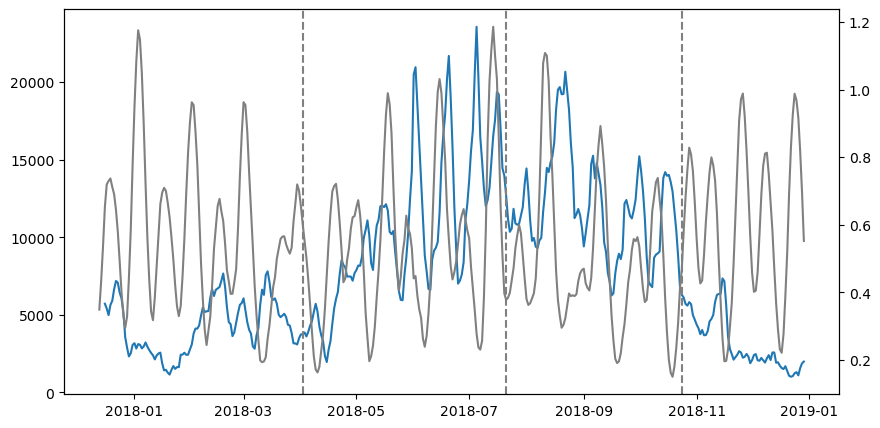

In [72]:
corr,p = stats.spearmanr(tides_sh[:-3],rostosouth.dropna())
print(corr)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna())
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='grey')
ax.axvline(date_tides_sh[110],ls='--',color='grey')
ax.axvline(date_tides_sh[220],ls='--',color='grey')
ax.axvline(date_tides_sh[315],ls='--',color='grey')